In [2]:
from google.colab import files
uploaded = files.upload()

Saving Dataset_nnpro1_modified_7.zip to Dataset_nnpro1_modified_7 (1).zip


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import cv2
import os
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from google.colab import files
import random

zip_path = "/content/Dataset_nnpro1_modified_7.zip"
extract_path = "/content/Dataset_nnpro1_modified_7"
shutil.unpack_archive(zip_path, extract_path)

#  paths after unzipping
data_root = os.path.join(extract_path, "Dataset_nnpro1_modified_7")
train_path = os.path.join(data_root, "Train_sp7")
test_path = os.path.join(data_root, "Test_sp7")

print("Train path:", train_path)
print("Test path:", test_path)

Train path: /content/Dataset_nnpro1_modified_7/Dataset_nnpro1_modified_7/Train_sp7
Test path: /content/Dataset_nnpro1_modified_7/Dataset_nnpro1_modified_7/Test_sp7


Final Train set: (2630, 256, 256, 1)
Final Train-Validation set: (658, 256, 256, 1)
Final Test set: (886, 256, 256, 1)
Final Test-Validation set: (380, 256, 256, 1)
Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step
Epoch 1: MSE=0.018163, R2=0.712740, Accuracy (R2x100)=71.27%
263/263 ━━━━━━━━━━━━━━━━━━━━ 21s 69ms/step - loss: 0.0456 - val_loss: 0.0177
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
Epoch 2: MSE=0.016282, R2=0.742491, Accuracy (R2x100)=74.25%
263/263 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - loss: 0.0176 - val_loss: 0.0159
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
Epoch 3: MSE=0.015309, R2=0.757886, Accuracy (R2x100)=75.79%
263/263 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - loss: 0.0158 - val_loss: 0.0150
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
Epoch 4: MSE=0.014173, R2=0.775855, Accuracy (R2x100)=77.59%
263/263 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - loss: 0.0150 - val_loss: 0.0138
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
Epoch 5: MSE=0.013165, R2=0.

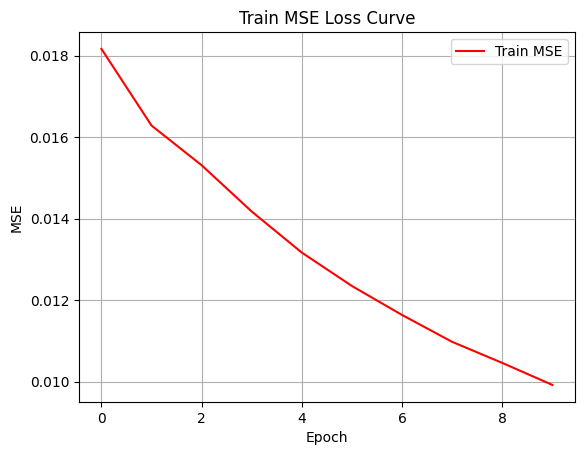

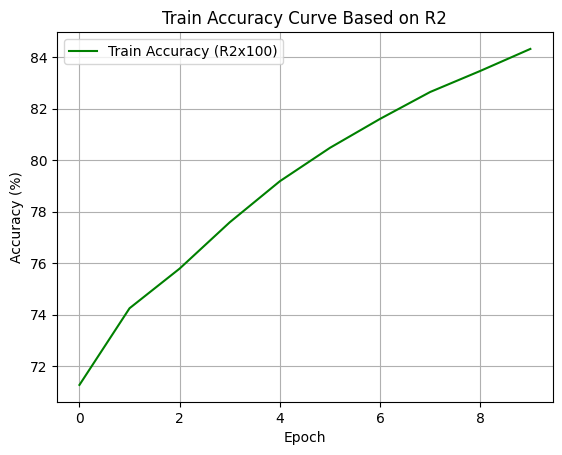

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


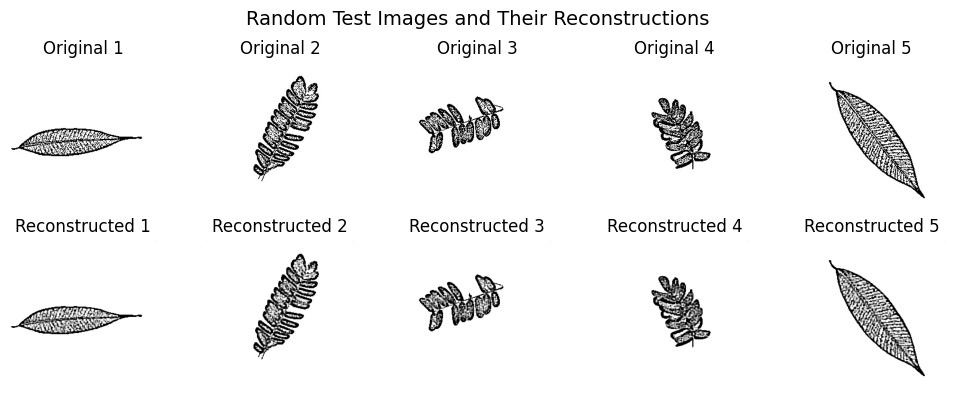

Model saved to: /content/drive/MyDrive/NNminipro1_modified/autoenco_corr_final_model_modified.h5


In [7]:
#  Load Images
def load_images_from_folder(folder_path):
    images = []
    for subfolder in sorted(os.listdir(folder_path)):
        subfolder_path = os.path.join(folder_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for filename in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = img.astype("float32") / 255.0
                img = np.expand_dims(img, axis=-1)
                images.append(img)
    return np.array(images)

#  Load Data
x_train_full = load_images_from_folder(train_path)
x_test_full = load_images_from_folder(test_path)

#  Split Train Data (80% Train, 20% Validation)
x_train, x_val = train_test_split(x_train_full, test_size=0.2, random_state=42)

#  Split Test Data (70% Test, 30% Validation)
x_test, x_test_val = train_test_split(x_test_full, test_size=0.3, random_state=42)

print("Final Train set:", x_train.shape)
print("Final Train-Validation set:", x_val.shape)
print("Final Test set:", x_test.shape)
print("Final Test-Validation set:", x_test_val.shape)

#  Define Autoencoder
input_img = Input(shape=(256, 256, 1))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Custom Callback for MSE & R2 Score
train_mse_list = []
train_r2_list = []

class MetricsLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        preds = self.model.predict(x_train)
        mse = mean_squared_error(x_train.flatten(), preds.flatten())
        r2 = r2_score(x_train.flatten(), preds.flatten())
        train_mse_list.append(mse)
        train_r2_list.append(r2 * 100)
        print(f"Epoch {epoch+1}: MSE={mse:.6f}, R2={r2:.6f}, Accuracy (R2x100)={r2*100:.2f}%")

#  Train Model
history = autoencoder.fit(x_train, x_train,
                          epochs=10,
                          batch_size=10,
                          shuffle=True,
                          callbacks=[MetricsLogger()],
                          validation_data=(x_val, x_val))

#  Reconstruction Accuracy Function
def reconstruction_accuracy(original, reconstructed, threshold=0.01):
    differences = np.abs(original - reconstructed)
    accurate_pixels = np.sum(differences < threshold)
    total_pixels = np.prod(original.shape)
    return (accurate_pixels / total_pixels) * 100

#  Predict on Train and Test
decoded_train = autoencoder.predict(x_train)
decoded_test = autoencoder.predict(x_test)

# Compute Accuracy
train_recon_accuracy = reconstruction_accuracy(x_train, decoded_train)
test_recon_accuracy = reconstruction_accuracy(x_test, decoded_test)

print(f"Train Reconstruction Accuracy: {train_recon_accuracy:.2f}%")
print(f"Test Reconstruction Accuracy: {test_recon_accuracy:.2f}%")


#  Evaluate on Test Set
decoded_test = autoencoder.predict(x_test)
test_mse = mean_squared_error(x_test.flatten(), decoded_test.flatten())
test_r2 = r2_score(x_test.flatten(), decoded_test.flatten())

print(f"\nTest MSE: {test_mse:.6f}")
print(f"Test R2 Score: {test_r2:.6f}")
print(f"Test Accuracy (R2x100): {test_r2 * 100:.2f}%")

#  Plot Loss Curve
plt.plot(train_mse_list, label='Train MSE', color='red')
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Train MSE Loss Curve")
plt.grid(True)
plt.legend()
plt.show()

# Plot Accuracy Curve
plt.plot(train_r2_list, label='Train Accuracy (R2x100)', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Train Accuracy Curve Based on R2")
plt.grid(True)
plt.legend()
plt.show()

#  Visualize 5 Random Reconstructions
random_indices = random.sample(range(len(x_test)), 5)
decoded_random = autoencoder.predict(x_test[random_indices])

plt.figure(figsize=(10, 4))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[idx].squeeze(), cmap='gray')
    plt.title(f"Original {i+1}")
    plt.axis("off")

    plt.subplot(2, 5, i + 6)
    plt.imshow(decoded_random[i].squeeze(), cmap='gray')
    plt.title(f"Reconstructed {i+1}")
    plt.axis("off")

plt.suptitle("Random Test Images and Their Reconstructions", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

#  Save Model to Google Drive
model_save_path = "/content/drive/MyDrive/NNminipro1_modified/autoenco_corr_final_model_modified.h5"
autoencoder.save(model_save_path)
print(f"Model saved to: {model_save_path}")
